In [38]:
from enum import Enum
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage
from langgraph.graph import Graph
from IPython.display import Image, display

# ======================================================
# MODELLI
# ======================================================

class TipoPersona(str, Enum):
    fisica = "fisica"
    giuridica = "giuridica"

class PersonaOutput(BaseModel):
    tipo: TipoPersona = Field(description="Tipo di persona: 'fisica' o 'giuridica'")

# modello intermedio (senza tipo)
class DettaglioNomeCognome(BaseModel):
    nome: str
    cognome: str

# output finale
class DettaglioPersonaFisica(DettaglioNomeCognome):
    tipo: TipoPersona = Field(default=TipoPersona.fisica)

class DettaglioPersonaGiuridica(BaseModel):
    ragione_sociale: str
    tipo: TipoPersona = Field(default=TipoPersona.giuridica)

# ======================================================
# LLM
# ======================================================

llm = ChatOllama(model="llama3.2", temperature=0)

# ======================================================
# NODI
# ======================================================

def classifica_anagrafica(input_str: str):
    prompt = f"""
    Determina se il seguente nome si riferisce a una persona fisica o giuridica.
    Rispondi solo con 'fisica' o 'giuridica'.

    Nome: {input_str}
    """
    result = llm.with_structured_output(PersonaOutput).invoke([HumanMessage(content=prompt)])
    return {"input_str": input_str, "classificazione": result}

def elabora_anagrafica(data: dict):
    classificazione = data["classificazione"]
    input_str = data["input_str"]

    if classificazione.tipo == TipoPersona.fisica:
        prompt = f"""
        Verifica all'interno della  seguente anagrafica qual'è il nome e qual'è il cognome.
        nel campo nome inserisci soltanto il nome e nel campo cognome inserisci soltanto il cognome.
        Rispondi in formato JSON con le chiavi 'nome' e 'cognome'.

        Nome completo: {input_str}
        """
        parsed = llm.with_structured_output(DettaglioNomeCognome).invoke([HumanMessage(content=prompt)])
        print(parsed)
        return DettaglioPersonaFisica(**parsed.model_dump())
    else:
        return DettaglioPersonaGiuridica(ragione_sociale=input_str)

def log_result(result):
    print(f"[LOG] Risultato finale: {result.model_dump()}")
    return result



In [39]:
# ======================================================
# GRAFO
# ======================================================

graph = Graph()
graph.add_node("classifica_anagrafica", classifica_anagrafica)
graph.add_node("elabora_anagrafica", elabora_anagrafica)
graph.add_node("log_result", log_result)
graph.add_edge("classifica_anagrafica", "elabora_anagrafica")
graph.add_edge("elabora_anagrafica", "log_result")
graph.set_entry_point("classifica_anagrafica")
graph.set_finish_point("log_result")
app = graph.compile()



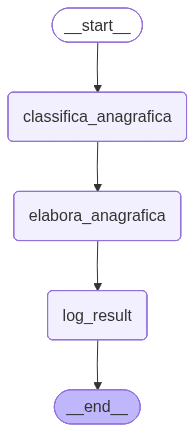

In [40]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [41]:
# ======================================================
# TEST
# ======================================================

for test in ["Michele Soncini", "Alfa S.R.L.", "Mario Russo"]:
    print(f"\n🧩 INPUT: {test}")
    result = app.invoke(test)
    print("📤 OUTPUT:", result.model_dump_json(indent=2))



🧩 INPUT: Michele Soncini
nome='Michele' cognome='Soncini'
[LOG] Risultato finale: {'nome': 'Michele', 'cognome': 'Soncini', 'tipo': <TipoPersona.fisica: 'fisica'>}
📤 OUTPUT: {
  "nome": "Michele",
  "cognome": "Soncini",
  "tipo": "fisica"
}

🧩 INPUT: Alfa S.R.L.
[LOG] Risultato finale: {'ragione_sociale': 'Alfa S.R.L.', 'tipo': <TipoPersona.giuridica: 'giuridica'>}
📤 OUTPUT: {
  "ragione_sociale": "Alfa S.R.L.",
  "tipo": "giuridica"
}

🧩 INPUT: Mario Russo
nome='Mario' cognome='Russo'
[LOG] Risultato finale: {'nome': 'Mario', 'cognome': 'Russo', 'tipo': <TipoPersona.fisica: 'fisica'>}
📤 OUTPUT: {
  "nome": "Mario",
  "cognome": "Russo",
  "tipo": "fisica"
}
